In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence

In [2]:
base_path = 'C:/Users/Alex/Desktop/Universidad/Third Course/First Semester/Vision & Learning/PROJECT 3/'
img_path = f'{base_path}Images/'
cap_path = f'{base_path}captions.txt'

In [3]:
df = pd.read_csv(cap_path)

In [4]:
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


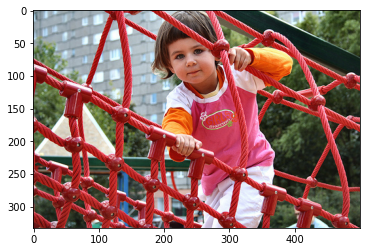

Caption - A child playing on a rope net .
Caption - A little girl climbing on red roping .
Caption - A little girl in pink climbs a rope bridge at the park .
Caption - A small child grips onto the red ropes at the playground .
Caption - The small child climbs on a red ropes on a playground .


In [5]:
data_idx = 25
image_path = img_path + "/" + df.iloc[data_idx,0]
img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

for i in range(data_idx, data_idx+5):
    print(f"Caption - {df.iloc[i,1]}")

In [6]:
import spacy

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Process a text
text = "spaCy is an awesome NLP library."
doc = nlp(text)

# Print tokens and their part-of-speech tags
for token in doc:
    print(f"{token.text}: {token.pos_}")


spaCy: INTJ
is: AUX
an: DET
awesome: ADJ
NLP: PROPN
library: NOUN
.: PUNCT


In [7]:
spacy_eng = spacy.load('en_core_web_sm')
text = "A little girl in pink climbs a rope bridge at the park ."
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['a',
 'little',
 'girl',
 'in',
 'pink',
 'climbs',
 'a',
 'rope',
 'bridge',
 'at',
 'the',
 'park',
 '.']

In [8]:
class Vocabulary:
    def __init__(self,freq_threshold):
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    
    def tokenize(self,text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self,sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

In [9]:
# Crear una instancia de la clase Vocabulary con un umbral de frecuencia de 2
vocab = Vocabulary(freq_threshold=1)

# Construir el vocabulario a partir de una lista de oraciones
sentences = ["This is a sample sentence.", "Another example sentence."]
vocab.build_vocab(sentences)

# Obtener la longitud del vocabulario
print(len(vocab))

# Numericalizar una oración
numericalized_sentence = vocab.numericalize("This is another example sentence.")
print(numericalized_sentence)


12
[4, 5, 10, 11, 8, 9]


In [10]:
v = Vocabulary(freq_threshold=1)
v.build_vocab(["This is a new city"])
print(v.stoi)
print(v.numericalize("This is a new city"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'new': 7, 'city': 8}
[4, 5, 6, 7, 8]


In [11]:
df = pd.read_csv(cap_path)
print(df["image"][0][::-1])

gpj.e0bc80b396_1028620001


In [12]:
class CustomDataset(Dataset):
    def __init__(self,root_dir,captions_file,transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [13]:
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [14]:
def show_image(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [15]:
dataset = CustomDataset(
        root_dir = img_path,
        captions_file = cap_path,
        transform = transforms
)

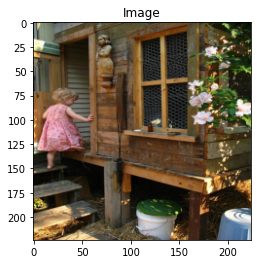

Token : tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence: 
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [16]:
img, caps = dataset[0]
# print(caps)
show_image(img,"Image")
print("Token :",caps)
print("Sentence: ")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [17]:


def caps_collate(batch, pad_idx, batch_first=False):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs, dim=0)
    
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=batch_first, padding_value=pad_idx)
    
    return imgs, targets

In [22]:

class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
        
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
#         print(f"shape - {(imgs)}")
#         print("----"*22)
        imgs = torch.cat(imgs,dim=0)
#         print(f"shape - {imgs}")
#         print("------")
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets


In [23]:
'''
BATCH_SIZE = 4
NUM_WORKER = 1

# Token para representar el relleno
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=lambda batch: caps_collate(batch, pad_idx=pad_idx, batch_first=True)
)
'''

'\nBATCH_SIZE = 4\nNUM_WORKER = 1\n\n# Token para representar el relleno\npad_idx = dataset.vocab.stoi["<PAD>"]\n\ndata_loader = DataLoader(\n    dataset=dataset,\n    batch_size=BATCH_SIZE,\n    num_workers=NUM_WORKER,\n    shuffle=True,\n    collate_fn=lambda batch: caps_collate(batch, pad_idx=pad_idx, batch_first=True)\n)\n'

In [24]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

In [25]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
#     print(f"captions - {captions[i]}")
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

In [ ]:

class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # Eliminar la última capa completamente conectada (clasificación)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embedding = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch_norm = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.batch_norm(self.embedding(features))
        return features

# Uso de ejemplo
# Supongamos que `image` es tu tensor de imagen (batch_size, channels, height, width)
# Asegúrate de que la imagen esté normalizada antes de pasarla al modelo

embed_size = 256  # Tamaño del embedding
encoder = ImageEncoder(embed_size)

# Imagina que tienes un batch de imágenes
image = torch.randn((64, 3, 224, 224))  # Ejemplo aleatorio, deberías cargar tus propias imágenes

# Obtener los embeddings
output = encoder(image)

print("Tamaño del embedding:", output.shape)
